# Import and sandbox

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import torch
import yaml

In [2]:
df = pd.read_parquet("/projects/cpjump1/jump/images_embeddings/resnet50_raw/metadata/load_wells/df_meta_raw_well.parquet")

In [9]:
plates = df['Metadata_Plate'].unique()
for plate in tqdm(plates):
    df_plate= df[(df['Metadata_Plate']==plate) & (df['Metadata_JCP2022']=='JCP2022_033924')]
    if len(df_plate) == 0:
        print(plate)

  0%|          | 0/1607 [00:00<?, ?it/s]

  9%|▊         | 140/1607 [00:08<01:28, 16.63it/s]

Dest210628-162003


 15%|█▍        | 238/1607 [00:14<01:21, 16.78it/s]

Dest210823-174240
Dest210823-174422


100%|██████████| 1607/1607 [01:36<00:00, 16.61it/s]


In [8]:

df['Metadata_JCP2022'].value_counts()

Metadata_JCP2022
JCP2022_033924    81340
JCP2022_037716     7666
JCP2022_064022     7663
JCP2022_025848     7660
JCP2022_046054     7654
                  ...  
JCP2022_010836        2
JCP2022_044729        2
JCP2022_100016        2
JCP2022_080384        1
JCP2022_090832        1
Name: count, Length: 112480, dtype: int64

In [5]:
df['path_embedding'] = df['Well_Embedding_mean']

In [6]:
df.to_parquet("/home/maxime/synrepos/phenospace/jump_pl/images_embeddings/ResNet50/metadata/load_wells/load_wells.parquet", index=False)

<Figure size 2000x1200 with 0 Axes>

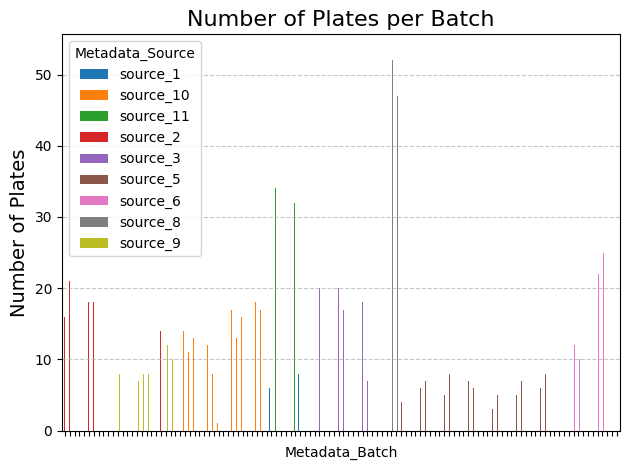

In [11]:
# Ensure no data is lost during grouping and unstacking
plate_count_per_batch = (
    df.groupby(["Metadata_Batch", "Metadata_Source"])["Metadata_Plate"]
    .nunique()
    .unstack(fill_value=0)  # Fill missing combinations with 0
)

# Plot with larger figure size and improved visibility
plt.figure(figsize=(20, 12))  # Further increase figure size
plate_count_per_batch.plot(kind='bar', stacked=False, edgecolor=None, width=0.8)

# Set title and y-axis label
plt.title("Number of Plates per Batch", fontsize=16)
plt.ylabel("Number of Plates", fontsize=14)

# Remove x-axis tick labels for a cleaner view
plt.gca().set_xticklabels([])

# Add grid lines for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


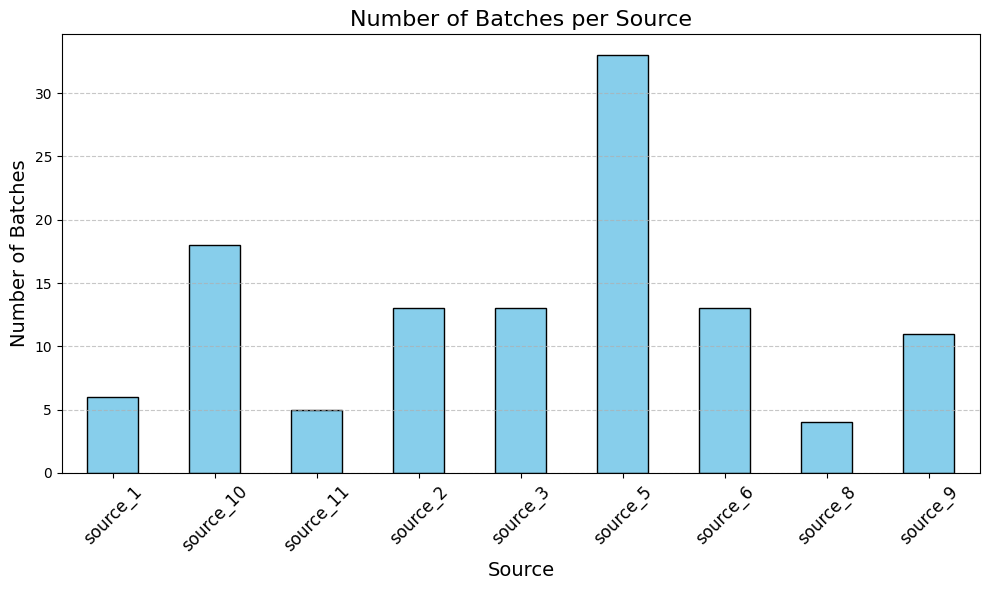

In [12]:
# Count the number of unique batches per source
batch_count_per_source = df.groupby("Metadata_Source")["Metadata_Batch"].nunique()

# Plot the data
plt.figure(figsize=(10, 6))  # Set figure size
batch_count_per_source.plot(kind="bar", color="skyblue", edgecolor="black")

# Add titles and labels
plt.title("Number of Batches per Source", fontsize=16)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Number of Batches", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add grid lines for y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


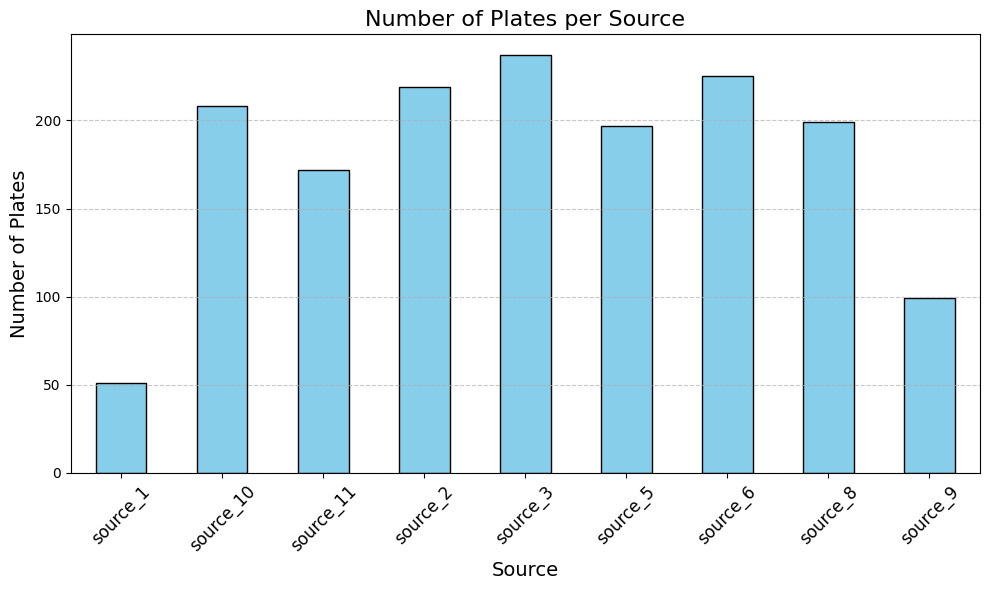

In [13]:
# Count the number of unique batches per source
batch_count_per_source = df.groupby("Metadata_Source")["Metadata_Plate"].nunique()

# Plot the data
plt.figure(figsize=(10, 6))  # Set figure size
batch_count_per_source.plot(kind="bar", color="skyblue", edgecolor="black")

# Add titles and labels
plt.title("Number of Plates per Source", fontsize=16)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Number of Plates", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add grid lines for y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


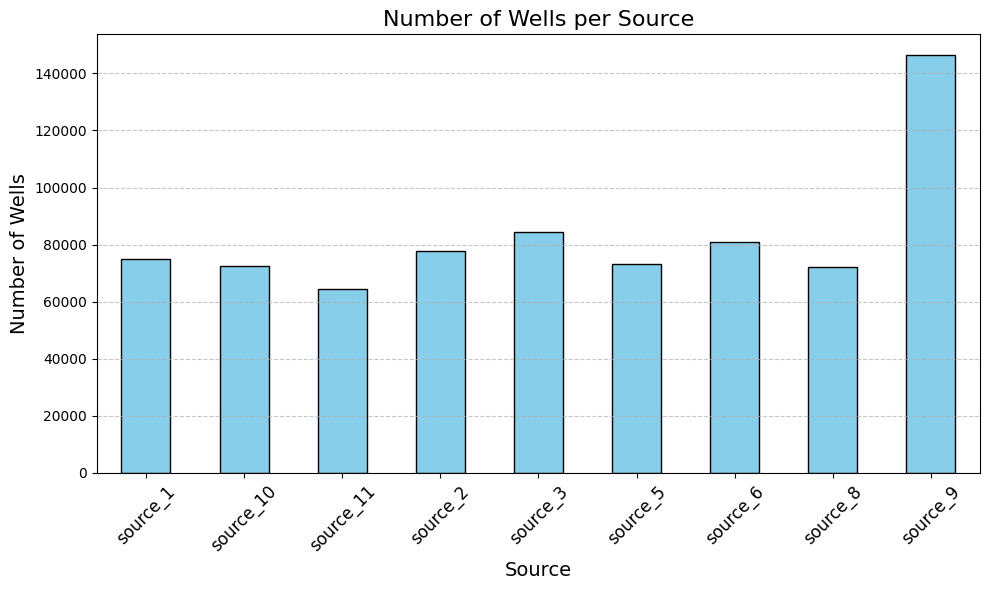

In [18]:
# Count the number of unique batches per source
batch_count_per_source = df.groupby("Metadata_Source")["Metadata_Well"].count()

# Plot the data
plt.figure(figsize=(10, 6))  # Set figure size
batch_count_per_source.plot(kind="bar", color="skyblue", edgecolor="black")

# Add titles and labels
plt.title("Number of Wells per Source", fontsize=16)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add grid lines for y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
from sklearn.model_selection import train_test_split

def select_test_data(df, test_size=0.2, random_state=42):
    """
    Select a fair test set for evaluating batch effect removal.

    Args:
        df (pd.DataFrame): The dataset containing Metadata_Batch and Metadata_Source.
        test_size (float): Proportion of data to include in the test set.
        random_state (int): Seed for reproducibility.

    Returns:
        pd.DataFrame: Test set DataFrame.
        pd.DataFrame: Train set DataFrame.
    """
    test_data = []
    train_data = []
    
    for source, source_df in df.groupby("Metadata_Source"):
        # Ensure stratification across Metadata_Batch
        batches = source_df["Metadata_Batch"].unique()
        selected_batches, remaining_batches = train_test_split(
            batches, test_size=test_size, random_state=random_state
        )

        # Add test and train batches
        test_data.append(source_df[source_df["Metadata_Batch"].isin(selected_batches)])
        train_data.append(source_df[source_df["Metadata_Batch"].isin(remaining_batches)])
    
    # Combine data across sources
    test_df = pd.concat(test_data, ignore_index=True)
    train_df = pd.concat(train_data, ignore_index=True)
    
    return train_df, test_df
